In [11]:
from dataset import myDataset_labelHM
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using MPS')
else :
    device = torch.device('cpu')
    print('Using CPU')

Using MPS


In [13]:
#fix random seed
torch.manual_seed(0)

In [14]:
#Parameters
path_csv = 'data/h&mdataset/articles.csv'
path_images = 'data/h&mdataset/images/'
batch_size = 64
ratio_frozen_layers =  0.6
num_epochs = 1
learning_rate = 0.0001

dataset = myDataset_labelHM(path_images, path_csv)
num_classes = dataset.get_num_classes()

#get a subset of the dataset
subset_indices = torch.randperm(len(dataset))[:10000]
num_samples_subset = len(subset_indices)

train_size = int(0.8 * num_samples_subset)
val_size = int(0.1 * num_samples_subset)
test_size = num_samples_subset - train_size - val_size

train_subset_indices = subset_indices[:train_size]
val_subset_indices = subset_indices[train_size:train_size+val_size]
test_subset_indices = subset_indices[train_size+val_size:]

train_subset = torch.utils.data.Subset(dataset, train_subset_indices)
val_subset = torch.utils.data.Subset(dataset, val_subset_indices)
test_subset = torch.utils.data.Subset(dataset, test_subset_indices)

#Save the indices in a file
torch.save(train_subset_indices, 'data/h&mdataset/train_subset_indices.pt')
torch.save(val_subset_indices, 'data/h&mdataset/val_subset_indices.pt')
torch.save(test_subset_indices, 'data/h&mdataset/test_subset_indices.pt')

In [15]:
print('Train subset size:', len(train_subset))

Train subset size: 8000


In [16]:
#Split train/validation/test 

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=False)

In [19]:
for batch in train_loader:
    images, labels, idx, img_path = batch
    print(idx)

tensor([ 81119,  70424,  60635,   1051,  81050,  23767,  47381, 101923,  88957,
         94759,   6984,  26651, 102527,  11812,   2677,  67383,  10519,  46630,
         28068,  66543,  48962,  60731,  86057, 101625,  84502,  76008,  22697,
         11242,  79460,   4412,  14421,  24221,  85036,  87602,   2304, 104906,
          7746,  33342,  18999,  61692,  63607,  15883,  84012,  21711,  82195,
        101037,  81158,  74237,  79738,  69648,  89698,  49331,  41143,  52951,
         17900,  34059,  83193,  20742,  42102,  70538,  42885,  56324,   7539,
         16578])
tensor([ 80403,  64076,  90293,  10383,    197,  39589,  77350, 103656,  19537,
         48574,  45663,  94207,  93341,  57825, 103493,  65515,   1229,  85475,
         61884,  26921,  41740, 102665,  22787,  57584,  11578,  17674,  31987,
         56714,   1300,  45603,  10332,  17489,    327,  13100,   2469,  47585,
         99257,  12221,   3737,  93298,  37414,  65238,  57441,  50673,   9499,
          4081,  29255,

KeyboardInterrupt: 

In [7]:
#Finetuning of a pretrained model resnet50


class ResNet50(nn.Module):
    def __init__(self, num_classes, ratio_frozen_layers=0.0):
        super(ResNet50, self).__init__()
        self.ration_frozen_layers = ratio_frozen_layers
        self.resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        self.resnet.train()
        self.fc = nn.Linear(2048, num_classes)
        #get the layers of the resnet model
        self.resnet_layers = list(self.resnet.children())
        self.numbers_of_layers = len(self.resnet_layers)
        self.numbers_of_frozen_layers = int(self.numbers_of_layers*self.ration_frozen_layers)
        #freeze the layers of the resnet model to a certain layer defined by "number of frozen layers"
        for i in range(0, self.numbers_of_frozen_layers):
            for param in self.resnet_layers[i].parameters():
                param.requires_grad = False
        
    
    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def show_number_frozen_layers(self):
        print(f'{self.numbers_of_frozen_layers} frozen layers out of {self.numbers_of_layers} layers')

model = ResNet50(num_classes, ratio_frozen_layers)
model.to(device)
model.show_number_frozen_layers()

#Loss and optimizer
criterion = nn.CrossEntropyLoss()

#Fine tune all layers of the model except the last one for which we cant a higher learning rate
optimizer = optim.Adam([
    {'params': model.resnet.parameters(), 'lr': learning_rate/100},
    {'params': model.fc.parameters(), 'lr': learning_rate}
])

Using cache found in /Users/jskaf/.cache/torch/hub/pytorch_vision_v0.6.0
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


5 frozen layers out of 9 layers


In [8]:
def train(model, train_loader, criterion, optimizer, epoch):
    print('Training epoch {}'.format(epoch+1))
    model.train()
    training_loss = 0.0
    index_batch = 0
    for batch in train_loader:
        images, labels ,_ ,_ = batch
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        training_loss += loss.item()

        
        #Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        index_batch += 1
        print('Batch {} out of {}'.format(index_batch, len(train_loader)), end='\r')
        # if index_batch%10 == 0:
        #     print('Batch {} out of {}'.format(index_batch, len(train_loader)))
    return training_loss/len(train_loader)

In [9]:
def evaluate(model, val_loader, epoch, criterion):
    global num_classes
    print('Evaluating epoch {}'.format(epoch+1))
    model.eval()
    validation_loss = 0.0
    #Validation and print of accuracy per class
    with torch.no_grad():
        class_correct = list(0. for i in range(num_classes))
        class_total = list(0. for i in range(num_classes))
        index_batch = 0
        for batch in val_loader:
            images, labels, _ , _= batch
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            index_batch += 1
            print('Batch {} out of {}'.format(index_batch, len(train_loader)), end='\r')
            # if index_batch%10 == 0:
            #     print('Batch {} out of {}'.format(index_batch, len(val_loader)))

        for i in range(num_classes):
            if class_total[i] == 0:
                print('No validation data for class {}'.format(i+1))
            else:
                print('Accuracy of class %5s : %2d %%' % (i+1, 100 * class_correct[i] / class_total[i]))
    return validation_loss/len(val_loader)
    

In [10]:
#Train the model
train_losses = []
validation_losses = []
for epoch in tqdm(range(num_epochs)):
    train_loss = train(model, train_loader, criterion, optimizer, epoch)
    validation_loss = evaluate(model, val_loader, epoch, criterion)
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)

  0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 1


/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clo

Evaluating epoch 125


/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clo

100%|██████████| 1/1 [01:58<00:00, 118.85s/it]

No validation data for class 1
No validation data for class 2
Accuracy of class     3 :  0 %
Accuracy of class     4 :  0 %
Accuracy of class     5 :  0 %
Accuracy of class     6 :  0 %
Accuracy of class     7 :  0 %
No validation data for class 8
Accuracy of class     9 :  0 %
Accuracy of class    10 :  0 %
Accuracy of class    11 :  0 %
Accuracy of class    12 :  0 %
No validation data for class 13
Accuracy of class    14 :  0 %
Accuracy of class    15 :  0 %
Accuracy of class    16 :  0 %
Accuracy of class    17 :  0 %
Accuracy of class    18 :  0 %
Accuracy of class    19 :  0 %
Accuracy of class    20 :  0 %
Accuracy of class    21 :  0 %
Accuracy of class    22 :  0 %
Accuracy of class    23 :  0 %
Accuracy of class    24 :  0 %
No validation data for class 25
Accuracy of class    26 :  0 %
Accuracy of class    27 :  0 %
Accuracy of class    28 :  0 %
Accuracy of class    29 :  0 %
Accuracy of class    30 :  0 %
Accuracy of class    31 :  0 %
Accuracy of class    32 :  0 %
Accura

In [11]:
#Save the model
torch.save(model.state_dict(), 'models/resnet_finetuned.pth')

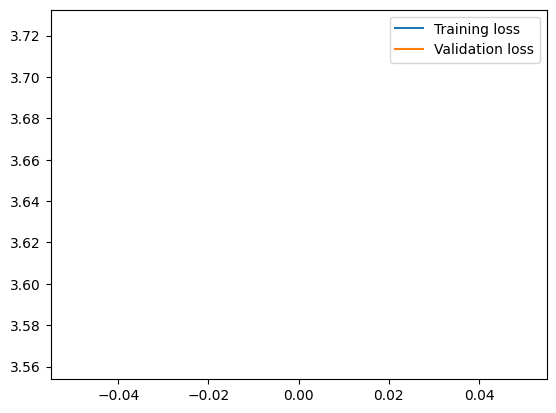

In [12]:
#Plot the losses and save them
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend()
plt.savefig('models/losses.png')
plt.show()

In [13]:
#Test the model for each class
def test(model, test_loader):
    global num_classes
    model.eval()
    with torch.no_grad():
        index_batch = 0
        class_correct = list(0. for i in range(num_classes))
        class_total = list(0. for i in range(num_classes))
        for batch in test_loader:
            images, labels, _ , _ = batch
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            index_batch += 1
            print('Batch {} out of {}'.format(index_batch, len(train_loader)), end='\r')
            # if index_batch%10 == 0:
            #     print('Batch {} out of {}'.format(index_batch, len(test_loader)))

        for i in range(num_classes):
            if class_total[i] == 0:
                print('No test data for class {}'.format(i))
            else:
                print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))
            
test(model, test_loader)

/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clo

Accuracy of     0 :  0 %
No test data for class 1
Accuracy of     2 :  0 %
Accuracy of     3 :  0 %
Accuracy of     4 :  0 %
Accuracy of     5 :  0 %
Accuracy of     6 :  0 %
Accuracy of     7 :  0 %
Accuracy of     8 :  0 %
Accuracy of     9 :  0 %
No test data for class 10
No test data for class 11
No test data for class 12
Accuracy of    13 :  0 %
Accuracy of    14 :  0 %
Accuracy of    15 :  0 %
Accuracy of    16 :  0 %
Accuracy of    17 :  0 %
No test data for class 18
Accuracy of    19 :  0 %
Accuracy of    20 :  0 %
Accuracy of    21 :  0 %
No test data for class 22
Accuracy of    23 :  0 %
No test data for class 24
Accuracy of    25 :  0 %
Accuracy of    26 :  0 %
Accuracy of    27 :  0 %
Accuracy of    28 :  0 %
Accuracy of    29 :  0 %
Accuracy of    30 :  0 %
Accuracy of    31 :  0 %
Accuracy of    32 :  0 %
Accuracy of    33 :  0 %
Accuracy of    34 :  0 %
No test data for class 35
Accuracy of    36 :  0 %
No test data for class 37
No test data for class 38
Accuracy of    3